In [59]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm

import pickle
import os

import bz2
import _pickle as cPickle

In [49]:
TWEMOJI_DATASET = './datasets/samples/combined_csv.csv'
EMOJI_MAPPINGS = './datasets/emoji_map_1791.csv'
pkl_dest = os.path.join('src', 'pkl_objects')

In [5]:
twemoji = pd.read_csv(TWEMOJI_DATASET)

In [6]:
mappings = pd.read_csv(EMOJI_MAPPINGS)

In [7]:
twemoji = twemoji.reindex(np.random.permutation(twemoji.index))

# Mappings

In [8]:
# we can see that we now have the dataframe that contain all 
# the emoji mappings
mappings.head(5) 

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
0,#️⃣,symbols,keycap number sign,[hash],0023-fe0f-20e3,"[keycap, symbol, pound, hash, number]",0023_fe0f_20e3,#️⃣,NaN,NaN,NaN
1,*️⃣,symbols,keycap asterisk,[asterisk],002a-fe0f-20e3,"[keycap, symbol, asterisk, star]",002a_fe0f_20e3,*️⃣,[:keycap_asterisk:],NaN,NaN
2,0️⃣,symbols,keycap digit zero,[zero],0030-fe0f-20e3,"[, keycap, symbol, number, zero, math]",0030_fe0f_20e3,0️⃣,NaN,NaN,NaN
3,1️⃣,symbols,keycap digit one,[one],0031-fe0f-20e3,"[, keycap, symbol, number, one, math]",0031_fe0f_20e3,1️⃣,NaN,NaN,NaN
4,2️⃣,symbols,keycap digit two,[two],0032-fe0f-20e3,"[, keycap, symbol, two, number, math]",0032_fe0f_20e3,2️⃣,NaN,NaN,NaN


# Cleaning and Preparing

In [9]:
# lets see how many columns 
# does the dataset have
twemoji.columns

Index(['id', 'annotations', 'id_text'], dtype='object')

In [10]:
# rename annotations to target
# rename id_text to tweet
twemoji = twemoji.rename(columns={"annotations":'target', "id_text":"text"})

In [11]:
twemoji.head() 

,id,target,text
1757955,742946477518016513,1424,NaN
2027923,743973288989208577,1107,NaN
1232892,747112080017338368,1110,luv u bb your support for the lgbt+ community ...
831378,742501417768898564,685,NaN
345908,744369429094481920,1388,NaN


In [12]:
# since the id column is no longer needed
# we can simply drop it
twemoji = twemoji.drop(columns=["id"])

In [13]:
twemoji.head()

,target,text
1757955,1424,NaN
2027923,1107,NaN
1232892,1110,luv u bb your support for the lgbt+ community ...
831378,685,NaN
345908,1388,NaN


In [14]:
# Lets check how many null values exist in 
# the dataset
twemoji['text'].isna().sum()

3878060

In [15]:
# We can't do much with null values
# So we drop them
twemoji = twemoji.dropna()

In [16]:
twemoji.head()

,target,text
1232892,1110,luv u bb your support for the lgbt+ community ...
1756511,350,"Oh Se-jong, gold medal winner for Korea in th..."
1739429,1436,For what
1221514,1056,'You the man in the relationship'
1734257,1424,That's bundles


In [17]:
# Lets check how big is the data set now
twemoji.shape

(88567, 2)

# Exploration

<AxesSubplot:xlabel='target'>

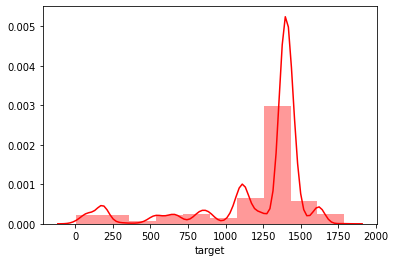

In [18]:
# lets see the distribution of our target values
sns.distplot(twemoji['target'], color='red', bins=10)

In [19]:
most_frequent = twemoji['target'].value_counts().idxmax() 
most_frequent

1381

In [20]:
# The laughing face emoji is the most popular in this dataset
mappings.loc[most_frequent]

Unnamed: 0                                                            😂
category                                                         people
title                                            face with tears of joy
shorts                                                            [joy]
unicode_alternates                                                  NaN
keywords              [emotion, cry, tear, joy, smiley, sarcastic, f...
ucode_short                                                       1f602
ucode                                                                 😂
aliases                                                             NaN
alt_title                                                           NaN
aliases_ascii                                               [:'), :'-)]
Name: 1381, dtype: object

In [25]:
# Lets see the 10 most frequently used emojis
top_twenty = twemoji['target'].value_counts()[:20].index.tolist() 
top_twenty

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [51]:
# lets see the mappings
mappings.loc[top_twenty].head()

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
1381,😂,people,face with tears of joy,[joy],NaN,"[emotion, cry, tear, joy, smiley, sarcastic, f...",1f602,😂,NaN,NaN,"[:'), :'-)]"
1447,🙄,people,face with rolling eyes,"[rolling_eyes, face_with_rolling_eyes]",NaN,"[emotion, eyes, rolling eyes, smiley, sarcasti...",1f644,🙄,[:face_with_rolling_eyes:],NaN,NaN
1424,😭,people,loudly crying face,[sob],NaN,"[emotion, sob, tear, cry, smiley, sad, heartbr...",1f62d,😭,NaN,NaN,NaN
1392,😍,people,smiling face with heart shaped eyes,[heart_eyes],NaN,"[emotion, heart, eye, love, smiley, face, beau...",1f60d,😍,NaN,smiling face with heart-shaped eyes,NaN
1389,😊,people,smiling face with smiling eyes,[blush],NaN,"[emotion, beautiful, good, eye, smiley, face, ...",1f60a,😊,NaN,NaN,NaN


In [27]:
# We see that there is a high density around 1000-1500
# lets reduce the number of emojis there exists to the
# top 10 emojis that exists in the dataset
# we could reduce the complexity of our problem. 
index_names = twemoji[~twemoji['target'].isin(top_twenty)].index
twemoji = twemoji.drop(index_names)

<AxesSubplot:xlabel='target'>

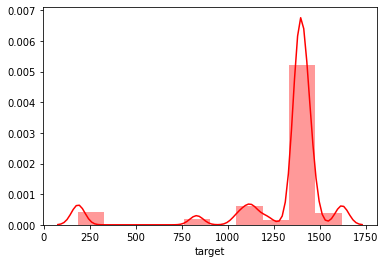

In [28]:
# lets see the distribution once again
sns.distplot(twemoji['target'], color='red', bins=10)

In [29]:
# For sanity check lets see if the remaining emojis
# are only the top ten emojis
twemoji['target'].value_counts().index.tolist() 

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [30]:
twemoji.shape

(44933, 2)

In [31]:
def tokenizer(text): 
    return text.split()

In [32]:
# Spliting test and test set
from sklearn.model_selection import train_test_split
X = twemoji['text'] 
y = twemoji['target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
def print_scores(model):
    print('Best parameter set: %s ' % model.best_params_)
    print('CV Accuracy: %.3f' % model.best_score_)
    clf = model.best_estimator_
    print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

In [39]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

In [40]:
lr_param_grid = [{'vect__ngram_range': [(1, 2),],
               'vect__stop_words' : [None],
               'vect__tokenizer' : [tokenizer], 
               'clf__penalty': ['l2'],
               'clf__C': [1.0,],
              }, 
              {
                'vect__ngram_range' : [(1, 1)], 
                'vect__stop_words' : [None],
                'vect__tokenizer' : [tokenizer,], 
                'vect__use_idf' : [False],
                'vect__norm' : [None],
                'clf__penalty' : ['l2'],
                'clf__C': [1.0,],
              }
             ] 

In [41]:
svm_param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                   'vect__stop_words' : [stop, None],
                   'vect__tokenizer' : [tokenizer],
                   'clf__kernel': ['rbf'],
                   'clf__gamma': [1e-3, 1e-4],
                   'clf__C': [1, 10, 100, 1000],
                  },
                  {
                    'vect__ngram_range' : [(1, 1)], 
                    'vect__stop_words' : [stop, None],
                    'vect__tokenizer' : [tokenizer], 
                    'vect__use_idf' : [False],
                    'vect__norm' : [None],
                    'clf__kernel': ['rbf'],
                    'clf__gamma': [1e-3, 1e-4],
                    'clf__C': [1, 10, 100, 1000], 
                   }
]

In [42]:
multiNB_param_grid = [
    {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words' : [stop, None],
        'vect__tokenizer' : [tokenizer, tokenizer_porter],
    },
    {
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3)], 
        'vect__stop_words' : [stop, None],
        'vect__tokenizer' : [tokenizer, tokenizer_porter], 
        'vect__use_idf' : [False],
        'vect__norm' : [None], 
    }
    
]

In [43]:
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))])
svm_tfidf = Pipeline([('vect', tfidf), ('clf', SVC(random_state=0))])
multiNB_tfidf = Pipeline([('vect', tfidf), ('clf', MultinomialNB())])

In [44]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, lr_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=1)
gs_svm_tfidf = GridSearchCV(svm_tfidf, svm_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs_multiNB_tfidf = GridSearchCV(multiNB_tfidf, multiNB_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [64]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [65]:
print_scores(gs_lr_tfidf)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x1631f6f80>} 
CV Accuracy: 0.337
Test Accuracy: 0.345


In [7]:
mappings.iloc[1381]['ucode']

'😂'

## Hashing Vectorizer

In [34]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [35]:
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)

In [36]:
# using logistic regression
sgdc_clf = SGDClassifier(loss='log', random_state=0, max_iter=1)

In [37]:
sgdc_clf.fit(vect.transform(X_train), y_train)

SGDClassifier(loss='log', max_iter=1, random_state=0)

In [38]:
# Accuracy
sgdc_clf.score(vect.transform(X_test), y_test)

0.23471810089020773

In [41]:
y_preds = sgdc_clf.predict(vect.transform(X_test))

In [43]:
from sklearn.metrics import f1_score

In [47]:
# F1 Score
f1_score(y_test, y_preds, average='weighted')

0.1515674650153954

##  GloVe

In [70]:
from sklearn.preprocessing import scale

In [54]:
embeddings_path = os.path.join('src', 'embeddings', 'glove.twitter.27B.25d.txt')

In [71]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [69]:
import gensim.downloader as api

glove_twitter = api.load("glove-twitter-200")

[==------------------------------------------------] 5.5% 41.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.1% 76.9/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.5% 117.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.9% 158.2/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.3% 199.3/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 32.0% 242.5/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.2% 289.7/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.4% 336.8/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.9% 386.4/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 56.0% 424.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.8% 446.2/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.4% 465.5/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 64.7% 491.1/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.2% 517.0/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.5% 549.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 75.8% 574.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.1% 607.5/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.7% 635.0/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 88.0% 667.8/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.3% 692.9/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.7% 725.6/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.5% 747.3/758.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [77]:
X_train_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'sum') for z in X_train]))
X_test_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'sum') for z in X_test]))

In [81]:
sgdc_clf_glove = SVC(random_state=0)

In [82]:
sgdc_clf_glove.fit(X_train_glove_sum, y_train)

SVC(random_state=0)

In [83]:
y_preds = sgdc_clf_glove.predict(X_test_glove_sum)

In [84]:
f1_score(y_test, y_preds, average='weighted')

0.15278044923239656

In [85]:
sgdc_clf_glove.score(X_test_glove_sum, y_test)

0.23887240356083086